predict fco2 levels for ocean surface

In [1]:
import pandas as pd
df_collocated = pd.read_parquet('../data/inference/gridded_2022-10-04/collocated_data.pq')

In [2]:
df_collocated.head()

,lat,lon,block_index,time,chl_globcolour,chl_globcolour_uncert,chl_globcolour_flags,time_globcolour,lat_globcolour,lon_globcolour,...,lat_sss_multiobs,lon_sss_multiobs,depth_sss_multiobs,time_sss_multiobs,sst_cci,sst_cci_uncertainty,ice_cci,time_sst_cci,lat_sst_cci,lon_sst_cci
0,-89.975,0.000000,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.979172,0.020839,...,-89.9375,0.0625,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.974998,0.025000
1,-89.975,103.054526,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.979172,103.062508,...,-89.9375,103.0625,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.974998,103.074997
2,-89.975,206.109052,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.979172,206.104172,...,-89.9375,206.0625,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.974998,206.125000
3,-89.975,309.163577,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.979172,309.145844,...,-89.9375,309.1875,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.974998,309.174988
4,-89.925,0.000000,0,2022-10-04,NaN,NaN,1,2022-10-04,-89.937508,0.020839,...,-89.9375,0.0625,0.0,2022-10-04,NaN,NaN,NaN,2022-10-05,-89.925003,0.025000


In [3]:
df_inference = df_collocated[((df_collocated['lat'] > 25) & (df_collocated['lat'] < 30)) &  
                            ((df_collocated['lon'] > 310) & (df_collocated['lon'] < 320))]

# nomralize lons to -180 to 180
df_inference['lon'] = (df_inference.loc[:, 'lon'] + 180) % 360 - 180

C:\Users\henry\AppData\Local\Temp\ipykernel_18888\638546147.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inference['lon'] = (df_inference.loc[:, 'lon'] + 180) % 360 - 180


In [4]:
df_inference.shape, df_collocated.shape

((19722, 39), (18350324, 39))

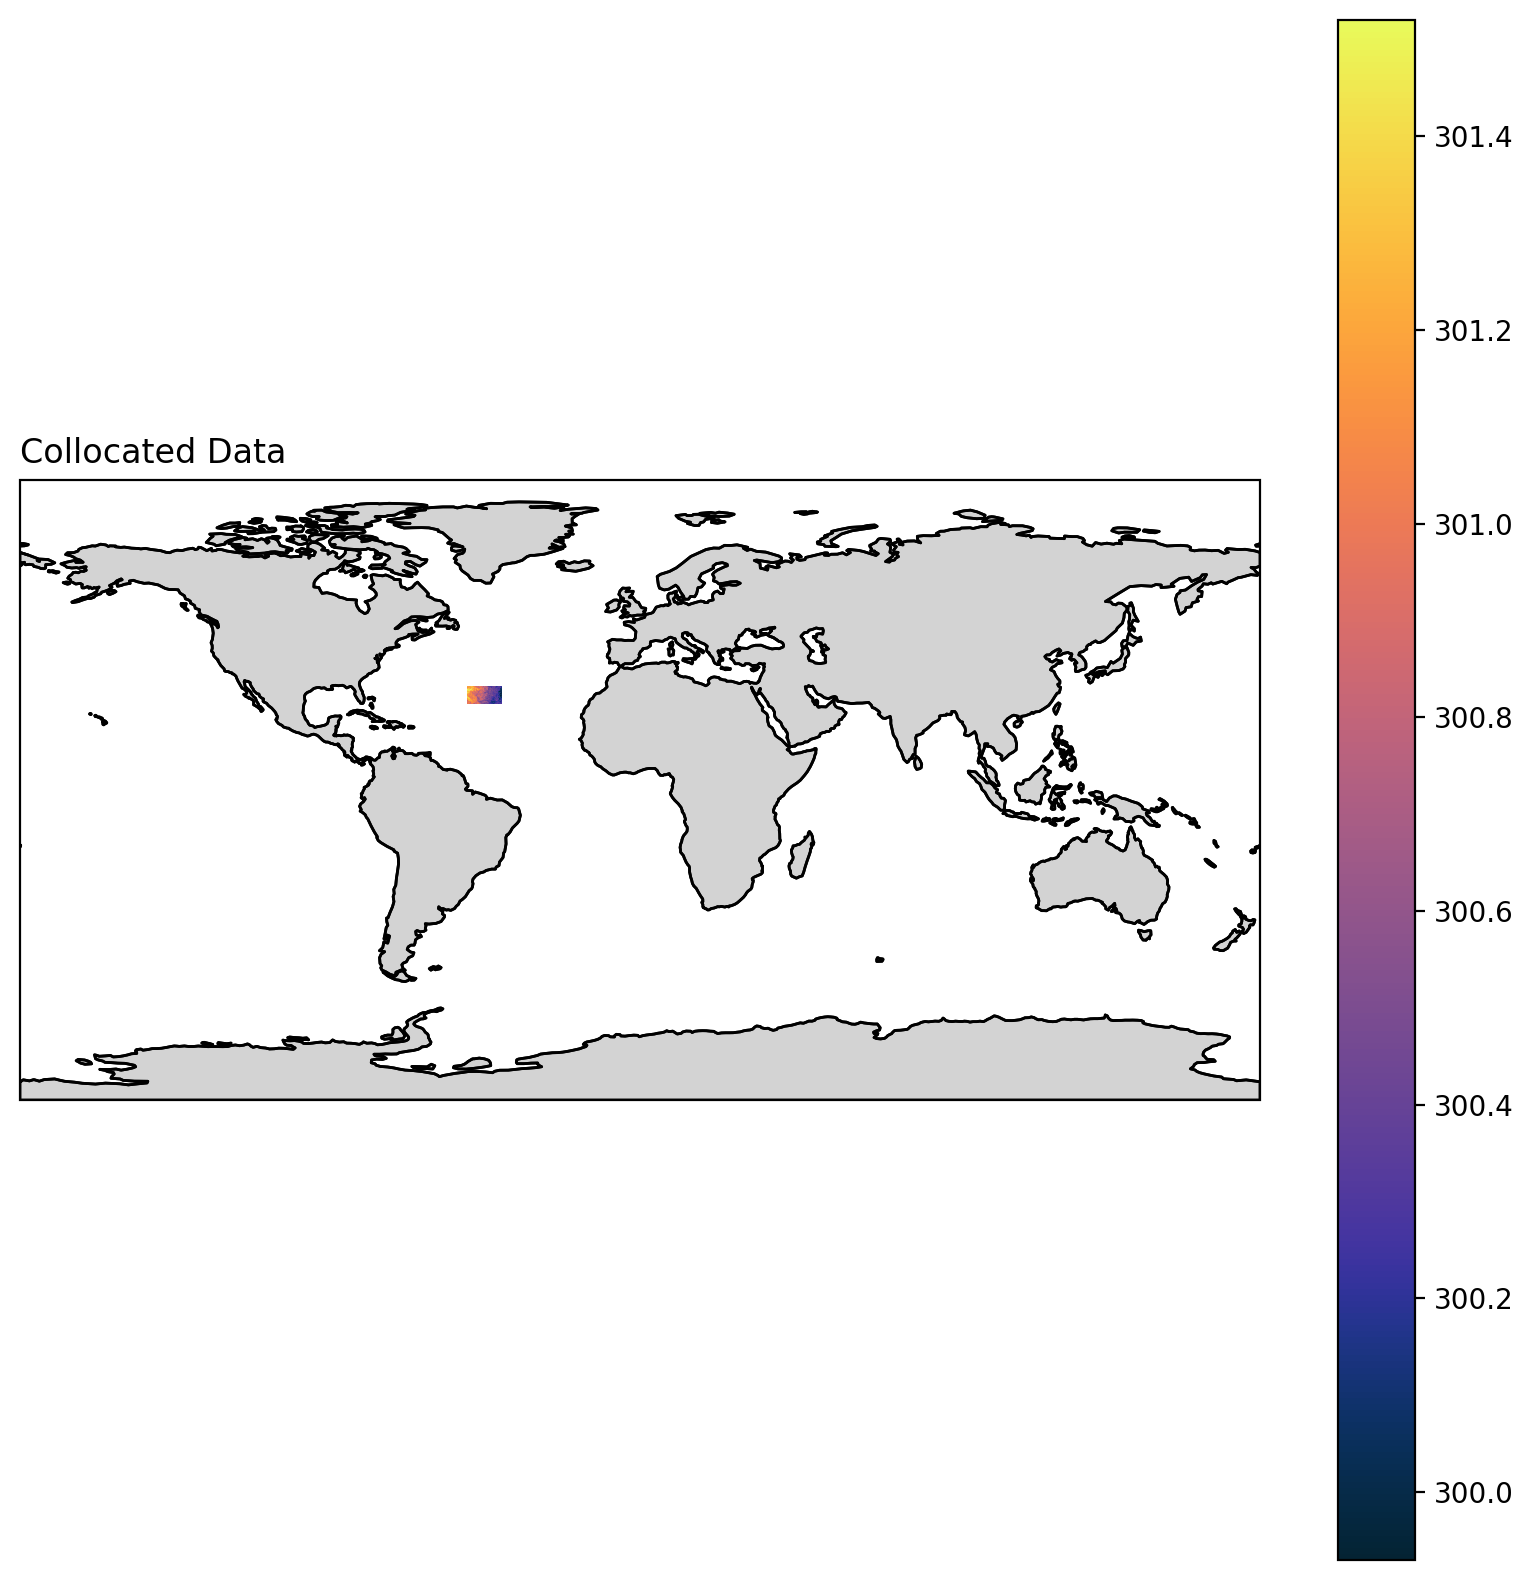

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cmocean import cm as cmo  # registers the cmocean colormaps to matplotlib
import numpy as np

# round the lat/lon to nearest 0.05 degree
df_inference_mesh = pd.DataFrame()
df_inference_mesh['lat'] = np.floor(df_inference['lat'] / 0.25) * 0.25
df_inference_mesh['lon'] = np.floor(df_inference['lon'] / 0.25) * 0.25
df_inference_mesh['sst_cci'] = df_inference['sst_cci']
df_inference_mesh = df_inference_mesh.drop_duplicates(subset=['lat', 'lon'], keep='last')

xds = df_inference_mesh.pivot(index='lat', columns='lon', values='sst_cci')
da = xr.DataArray(xds.values,
                  coords={'lat': xds.index.values, 'lon': xds.columns.values},
                  dims=['lat', 'lon'])


fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE, zorder=2, edgecolor='black')

ax.set_title('Collocated Data', fontsize=12, loc='left')

# plot data with meshgrid
# mesh = ax.pcolormesh(da.lon, da.lat, da, cmap=cmo.thermal, shading='auto',
#                      transform=ccrs.PlateCarree(), zorder=5)
da.plot.imshow(cmap='cmo.thermal', ax=ax, add_colorbar=True, transform=ccrs.PlateCarree())

# plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.02, aspect=40, label='SST (°C)')

# ax.set_title('Gridded SST (0.5° resolution)', fontsize=16, loc='left')
plt.show()

In [6]:
import numpy as np
# df_inference = df_inference[:400]
print(f"shape of df_inference: {df_inference.shape}")
cols = ['sst_cci', 'sss_cci', 'chl_globcolour', 'lat', 'lon']

def segment_to_np(segment):
    # convert the segment to a numpy array
    values = np.full((1, len(cols), 64), np.nan, dtype=np.float32)
    n_values = segment.shape[0]
    values[0, :, :n_values] = segment.values[:].T
    return values

inf_ds_blocks = df_inference.groupby(['lat', 'block_index'])[cols].apply(segment_to_np)
inf_ds = np.vstack(inf_ds_blocks.values)
print(f"shape of inf_ds2: {inf_ds.shape}")

shape of df_inference: (19722, 39)
shape of inf_ds2: (406, 5, 64)


In [8]:
# count number of rows in inf_ds that contain any NaN values
num_nan_rows = np.sum(np.isnan(inf_ds[:, 2, :]).any(axis=1))
print(f"Total number of rows: {inf_ds.shape[0]}")
print(f"Number of rows with NaN values: {num_nan_rows}")
nan_rows = np.where(np.isnan(inf_ds[:, 2, :]).any(axis=1))[0]

Total number of rows: 406
Number of rows with NaN values: 199


In [9]:
# inspect lat and lon values in inf_ds of some rows
inf_ds[0, 3, :], inf_ds[0, 4, :]

(array([25.025, 25.025, 25.025, 25.025, 25.025, 25.025, 25.025, 25.025,
        25.025, 25.025, 25.025, 25.025, 25.025, 25.025, 25.025, 25.025,
        25.025, 25.025, 25.025, 25.025, 25.025, 25.025, 25.025, 25.025,
        25.025,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan],
       dtype=float32),
 array([-49.99504 , -49.945415, -49.895794, -49.84617 , -49.796543,
        -49.746918, -49.697292, -49.64767 , -49.598045, -49.54842 ,
        -49.498795, -49.44917 , -49.399548, -49.349922, -49.300297,
        -49.25067 , -49.201046, -49.151424, -49.1018  , -49.052174,
        -49.00255 , -48.952923, -48.9033  , -48.853676, -48.80405 ,
               nan,        nan,        nan,        nan,     

In [77]:
from torch.utils.data import DataLoader
from fco2models.utraining import  full_denoise
from fco2models.models import  UNet2DModelWrapper
import json
from diffusers import DDPMScheduler, UNet1DModel
import torch

def load_model(save_dir, model_path, model_class):
    #read model hyperparameters
    with open(save_dir+'hyperparameters.json', 'r') as f:
        params = json.load(f)

    with open(save_dir+'losses.json', 'r') as f:
        losses = json.load(f)
    
    model_params = params['model_params']
    noise_params = params['noise_params']

    # load the model
    model = model_class(**model_params)
    model.load_state_dict(torch.load(save_dir+model_path))
    model.eval()
    noise_scheduler = DDPMScheduler(**noise_params)

    return model, noise_scheduler, params, losses

unet2d_renko190, noise_scheduler, params, _= load_model('../models/renko/unet2d_fixsplit/', 'e_220.pt', UNet2DModelWrapper)

train_means = params['train_means']
train_stds = params['train_stds']
train_maxs = params['train_maxs']
train_mins = params['train_mins']
inf_ds_normalized = np.zeros_like(inf_ds)
for i in range(len(train_means[1:])):
    inf_ds_normalized[:, i, :] = 2 * (inf_ds[:, i, :] - train_mins[i]) / (train_maxs[i] - train_mins[i]) - 1
print(np.nanmean(inf_ds_normalized[:, 1, :]), np.nanstd(inf_ds_normalized[:, 1, :]))
n_rec = 20
context = torch.from_numpy(np.concatenate([inf_ds_normalized]*n_rec, axis=0)).float()
context_loader = DataLoader(context, batch_size=128, shuffle=False)
with torch.no_grad():
    samples = full_denoise(unet2d_renko190, noise_scheduler, context_loader, jump=10)

-14.521101 0.009660414
Training on cuda


Inference:  91%|█████████ | 58/64 [08:20<00:51,  8.63s/it, timestep=tensor(649)]


KeyboardInterrupt: 

In [11]:
samples.shape

(8120, 1, 64)

In [63]:
n = inf_ds.shape[0]
res = np.zeros((n, n_rec, inf_ds.shape[2]))
for i in range(n_rec):
    res[:, i, :] = samples[i*n:(i+1)*n, 0, :]

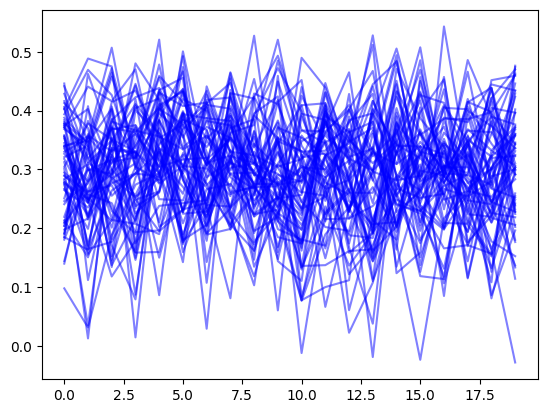

In [ ]:
import matplotlib.pyplot as plt

plt.plot(res[100, :, :].T, label='sample 1', color ='blue', alpha=0.5)
plt.show()

In [73]:
res[200, :, :]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(20, 64))

In [65]:
# plot 
lats = inf_ds[:, 3, :][:, np.newaxis]
lons = inf_ds[:, 4, :][:, np.newaxis]
res_lats_lons = np.concatenate([res, lats, lons], axis=1)

columns = [f'rec_{i}' for i in range(n_rec)] + ['lat', 'lon']
print(res_lats_lons[:, i, :].shape)
df_res = pd.DataFrame(np.array([res_lats_lons[:, i, :].flatten() for i in range(n_rec + 2)]).T, columns=columns)


(406, 64)


In [66]:
406 * 64

25984

In [67]:
df_res['rec_0'].isna().sum()
# check for infs
df_res.rec_0.iloc[100:110]

100    0.266005
101    0.268126
102    0.081919
103    0.357857
104    0.260168
105    0.246900
106    0.398758
107    0.350348
108    0.262053
109    0.375699
Name: rec_0, dtype: float64

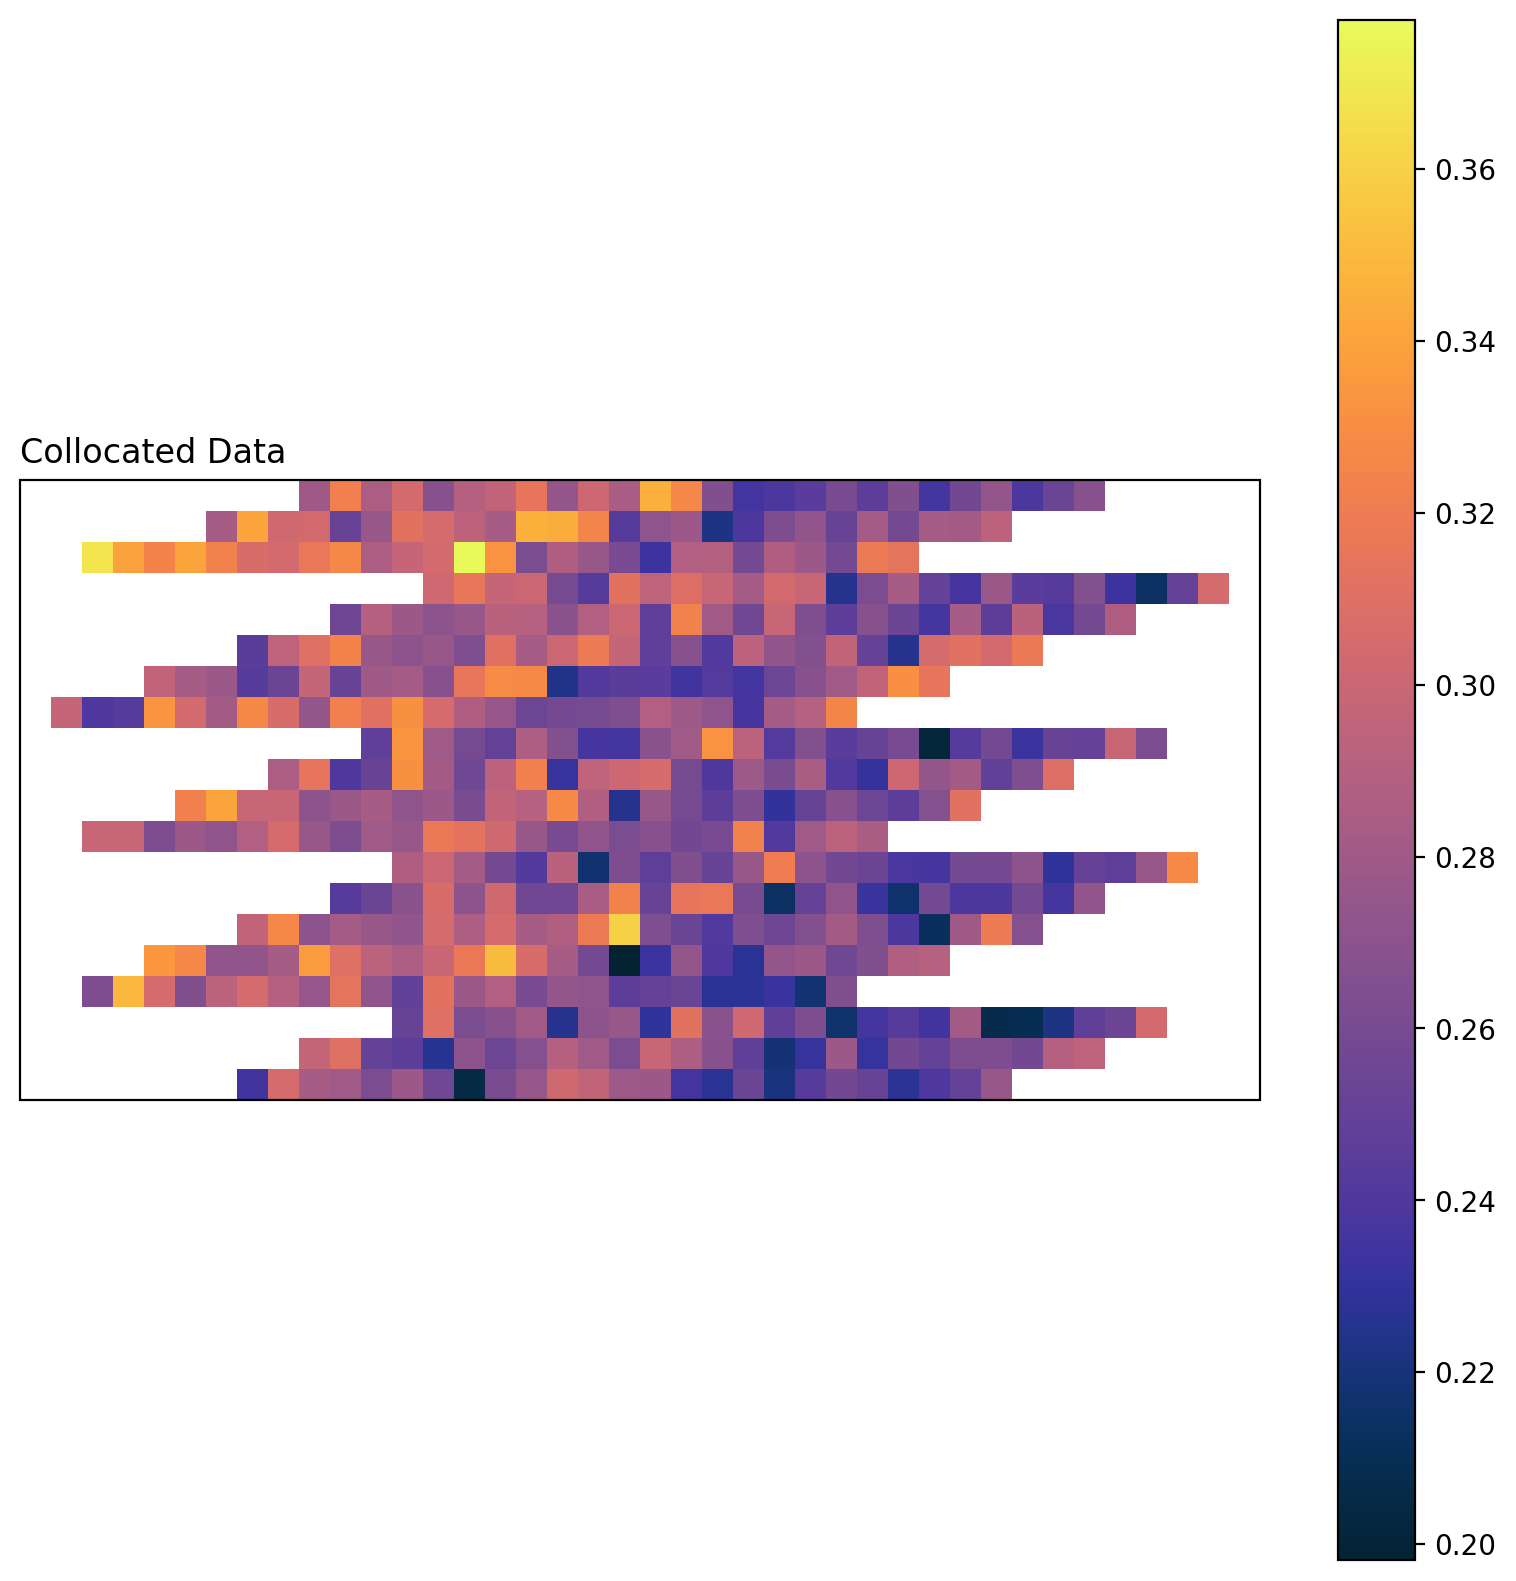

In [69]:
# round the lat/lon to nearest 0.05 degree
df_inference_mesh = pd.DataFrame()
df_inference_mesh['lat'] = np.floor(df_res['lat'] / 0.25) * 0.25
df_inference_mesh['lon'] = np.floor(df_res['lon'] / 0.25) * 0.25
df_inference_mesh['pred'] = df_res[[f'rec_{i}' for i in range(n_rec)]].mean(axis=1)
# drop rows with NaN values in lat/lon
df_inference_mesh = df_inference_mesh.dropna(subset=['lat', 'lon'])

df_inference_mesh = df_inference_mesh.drop_duplicates(subset=['lat', 'lon'], keep='last')

xds = df_inference_mesh.pivot(index='lat', columns='lon', values='pred')
da = xr.DataArray(xds.values,
                  coords={'lat': xds.index.values, 'lon': xds.columns.values},
                  dims=['lat', 'lon'])


fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.set_global()
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE, zorder=2, edgecolor='black')

ax.set_title('Collocated Data', fontsize=12, loc='left')

# plot data with meshgrid
# mesh = ax.pcolormesh(da.lon, da.lat, da, cmap=cmo.thermal, shading='auto',
#                      transform=ccrs.PlateCarree(), zorder=5)
da.plot.imshow(cmap='cmo.thermal', ax=ax, add_colorbar=True, transform=ccrs.PlateCarree())

# plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.02, aspect=40, label='SST (°C)')

# ax.set_title('Gridded SST (0.5° resolution)', fontsize=16, loc='left')
plt.show()